## Big Data in Finance Assignment 2

Group 3, members: 
* Karim Kharchafi
* Jeremy Tan
* Bharat Rao

# Libaries Import

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Currency and Window Size Selection

In [2]:
# Currencies: 'AUD','CAD','CHF','JPY','GBP','EUR','NOK','SEK','NZD','AUD_1'
# Change the name of the currency by one of the above and then run the code
Currency = 'AUD_1'
# Choose the size of the window by setting it here below
WindowSize = 24
# Value of Epsilon for the Lasso Model
epsilon = 1e-20
# Choose the option to either start with all data available by setting Option = 1
# or for Tarun's data only by setting Option = 2
Option = 1
# Length of the Moving Averages (in months)
n1 = 3
n2 = 12

In [3]:
if Currency == 'AUD_1':
    length = 245
else:
    length = 413 

# Read Data

In [4]:
data_file = pd.read_excel('FX.xlsx',sheetname = Currency)
data_file.head()

,Date,Binary Target,FX Spot Change,FX Spot,EuroDep,MoneySupply,IndProduction,CPI,Balance of Trade ($Bn),Foreign Reserves ($B),...,IPDiff,MSDiff,CPI_Change,US_CPI_Change,MS_Change,US_MS_Change,ID_Change,US_ID_Change,ED_Change,US_ED_Change
0,199001,0,0.000000,0.7685,17.895100,39.970082,145.729091,326.872959,-873.0,16.8567,...,0.016628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,199002,0,-0.010991,0.7601,16.124014,40.442498,147.304537,328.827356,-170.0,16.6115,...,0.018915,0.005928,0.008110,0.003503,0.001094,0.007251,0.006944,0.011928,0.023257,0.095310
2,199003,0,-0.006997,0.7548,15.154364,40.701594,148.879985,330.781754,-337.0,15.9146,...,0.025282,0.006453,0.008045,0.000000,0.016122,0.004895,0.006897,0.000185,-0.062242,-0.095310
3,199004,0,-0.006380,0.7500,15.144930,41.669796,147.544724,332.573286,-328.0,15.4750,...,0.016403,-0.014803,0.007981,0.003490,0.007828,0.001811,0.000687,0.007197,0.084971,0.095310
4,199005,1,0.023456,0.7678,14.563662,41.856309,146.209464,334.364814,-221.0,17.2073,...,0.006278,-0.007475,0.007918,0.006944,-0.002102,0.008560,0.000687,0.003671,0.001404,0.127833


## Split Dataset into Data/Target

In [5]:
# Split Dataset into Data/Target
if Option == 1:
    level_target = data_file['FX Spot Change']
    binary_target = data_file['Binary Target']
    data = pd.DataFrame(data_file.drop(['FX Spot Change','Binary Target','Date'],1))
else:
    level_target = data_file['FX Spot Change']
    binary_target = data_file['Binary Target']
    data = data_file[['EuroDepChange','IPDiff','MSDiff','InflationDiff']]

In [6]:
data.head()

,FX Spot,EuroDep,MoneySupply,IndProduction,CPI,Balance of Trade ($Bn),Foreign Reserves ($B),Unemployment Rate,Gold Price,WTI,...,IPDiff,MSDiff,CPI_Change,US_CPI_Change,MS_Change,US_MS_Change,ID_Change,US_ID_Change,ED_Change,US_ED_Change
0,0.7685,17.895100,39.970082,145.729091,326.872959,-873.0,16.8567,5.8,415.05,22.68,...,0.016628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.7601,16.124014,40.442498,147.304537,328.827356,-170.0,16.6115,5.9,407.70,21.54,...,0.018915,0.005928,0.008110,0.003503,0.001094,0.007251,0.006944,0.011928,0.023257,0.095310
2,0.7548,15.154364,40.701594,148.879985,330.781754,-337.0,15.9146,6.1,368.50,20.28,...,0.025282,0.006453,0.008045,0.000000,0.016122,0.004895,0.006897,0.000185,-0.062242,-0.095310
3,0.7500,15.144930,41.669796,147.544724,332.573286,-328.0,15.4750,6.4,367.75,18.54,...,0.016403,-0.014803,0.007981,0.003490,0.007828,0.001811,0.000687,0.007197,0.084971,0.095310
4,0.7678,14.563662,41.856309,146.209464,334.364814,-221.0,17.2073,6.2,363.05,17.40,...,0.006278,-0.007475,0.007918,0.006944,-0.002102,0.008560,0.000687,0.003671,0.001404,0.127833


## Helper Functions

In [7]:
def movingAverage(prices, n):

    movingAverage = []
    step = 0
    if len(prices) < n: 
        return print('There are not enough prices to compute the ' + str(n) + ' day MA')
    else:
        for i in range(step,n-1):
            movingAverage.append(None)
    for i in range(n,len(prices)+1):     
        MA = float(sum(prices[step:i])/n)        
        movingAverage.append(MA)
        step += 1
    return movingAverage

def crossOvers(prices1,prices2):

    crossovers = []
    higherIndex = 0    
    i = 0
    l = []
    while prices1[i] == None or prices2[i] == None:
        i += 1    
    
    if prices1[i] > prices2[i]:
        higherIndex = 1
    else:
        higherIndex = 2
            
    for n in range(i,len(prices1)):
        if prices1[n] > prices2[n] and higherIndex == 2:
            higherIndex = 1
            l = [n,higherIndex]
            crossovers.append(l)
        elif prices1[n] < prices2[n] and higherIndex == 1:
            higherIndex = 2
            l = [n,higherIndex]
            crossovers.append(l)
    return crossovers
    
def makeTrades(money, prices, crossovers):
    """
    Given an initial cash position, use a list of crossovers to make trades
    
    Input: money - initial cash position; prices - list of prices (ordered by time); crossovers - list of crossovers     
    Output: currentValue - list of value of position (either in stock value or cash) at each time index    
    
    Assume each item crossovers[i] is a list [timeIndex,buyIndex]    
    
    Assume that buyIndex = 1 means that short-term MA becomes higher than long term at this timeIndex
    buyIndex = 2 means that long-term MA becomes higher than short term.    

    You would like to buy at any timeIndex where crossover's buyIndex indicates 1, sell at 2. 
    
    That is, you want to buy whenever SHORT-TERM MA becomes higher than LONG-term (AND you have a cash position),
    and sell when the opposite cross-over occurs (AND you have a stock position).
    
    Use all money/stock available to buy/sell at the current price: you will always hold either stocks or cash, but never both.

    Assume fractional stock quantities, no transaction fees.      
    """  
    cashPosition = money
    stockPosition = 0
    portfolioValue = []
    IndexStarting = 0
    stockValue = 0
    i = 0
    
    while crossovers[i][1] != 1:
        i += 1
    
    IndexStarting = crossovers[i][0]
    
    for n in range(0,IndexStarting):
        portfolioValue.append(cashPosition)
        
    try: 
        for n in range(IndexStarting,len(prices)):
            if crossovers[i][0] == n and cashPosition > 0:
                stockPosition = cashPosition/prices[crossovers[i][0]]
                stockValue = stockPosition * prices[n]
                portfolioValue.append(stockValue)
                cashPosition = 0 
                i += 1
            elif crossovers[i][0] == n and stockPosition > 0:
                cashPosition = stockPosition*prices[crossovers[i][0]]
                portfolioValue.append(cashPosition)
                stockPosition = 0
                i += 1
            else:
                if stockPosition > 0:
                    stockValue = stockPosition*prices[n]
                    portfolioValue.append(stockValue)
                else:
                    portfolioValue.append(cashPosition)    
    except IndexError:
        if stockPosition > 0:
            stockValue = stockPosition*prices[n]
            portfolioValue.append(stockValue)
        else:
            portfolioValue.append(cashPosition)
    return portfolioValue         
            
def MAvsBaH(n1,n2,startingMoney):
    """
    perform comparison between moving average crossover strategy and buy and hold
    Assume n1 < n2
    """
    
    # Get prices    
    closingPrices = data_file['FX Spot']

    # Moving averages
    ma1 = movingAverage(closingPrices,n1)
    ma2 = movingAverage(closingPrices,n2)  
    
    # Crossovers
    cos = crossOvers(ma1,ma2)
    
    # Make trades using crossover strategy, get list of values
    MAvalues = makeTrades(startingMoney,closingPrices,cos)    
    
    # Get buy and hold strategy values
    firstValue = closingPrices[n2-1] # start trading at same point in time
    BHvalues = [p/firstValue*startingMoney for p in closingPrices] # List comprehension for convenient looping
    
    print("Buy and hold: " + str(BHvalues[-1]))
    print("Crossover MA: " + str(MAvalues[-1]))
    
    return [BHvalues, MAvalues]  

## Linear Regression

In [8]:
# Input Initialisation
Lbound = 0
Ubound = WindowSize
Tbound = WindowSize

X_train = data.iloc[Lbound:Ubound, :]
Y_train = level_target.iloc[Lbound:Ubound]
X_test = data.iloc[Tbound-1, :]
Y_test = level_target.iloc[Tbound]

# One error RMSE
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,Y_train)
predictions = lm.predict(X_test)
predictions

RMSE = np.sqrt((predictions - Y_test)**2)
RMSE

/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.02299448])

In [9]:
# Setting up data for Models
Model_SE_list = []
HM_SE_list = []
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

Lbound = 0
Ubound = WindowSize
Tbound = WindowSize

for i in range(WindowSize, length):
    X_train = data.iloc[Lbound:Ubound, :]
    Y_train = level_target.iloc[Lbound:Ubound]
    X_test = data.iloc[Tbound-1, :]
    Y_test = level_target.iloc[Tbound]

    # Linear Regression
    lm.fit(X_train,Y_train)
    predictions = lm.predict(X_test)
    Model_SE_list.append((predictions[0] - Y_test)**2)
    
    # Historical Mean
    historical_mean = np.mean(Y_train)
    HM_SE_list.append((historical_mean - Y_test)**2)
    
    Lbound = Lbound+1
    Ubound = Ubound+1
    Tbound = Tbound+1

/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

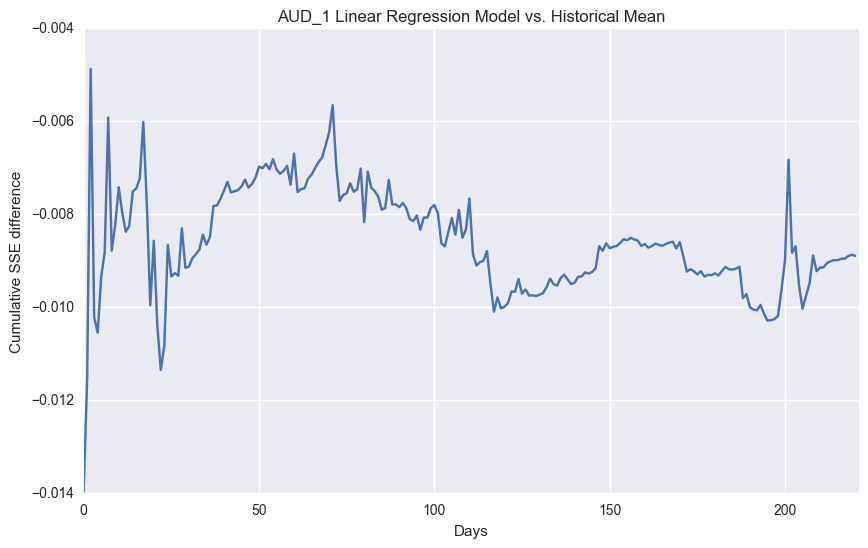

In [10]:
# CSSE 
RMSE_list = []
HM_SE_list = np.asarray(HM_SE_list).cumsum()
Model_SE_list = np.asarray(Model_SE_list).cumsum()

for i in range(0,len(HM_SE_list)):
    HM_SE_list[i] = HM_SE_list[i] / (i+1)
    Model_SE_list[i] = Model_SE_list[i] / (i+1)
    RMSE = np.sqrt(HM_SE_list[i]) - np.sqrt(Model_SE_list[i])
    RMSE_list.append(RMSE)

plt.figure(figsize=(10,6))
plt.plot(np.asarray(RMSE_list))
days = length - WindowSize
plt.xlim([0,days])
plt.xlabel('Days')
plt.ylabel('Cumulative SSE difference')
plt.title(Currency + ' Linear Regression Model vs. Historical Mean')

## Linear Model with Lasso

In [11]:
# Setting up data for Lasso Model
lasso_Model_SE_list = []
lasso_HM_SE_list = []
lasso_coefs_list = []
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv = 10, eps = epsilon, max_iter=10000, normalize = True)

Lbound = 0
Ubound = WindowSize
Tbound = WindowSize

for i in range(WindowSize, length):
    lasso_X_train = data.iloc[Lbound:Ubound, :]
    lasso_Y_train = level_target.iloc[Lbound:Ubound]
    lasso_X_test = data.iloc[Tbound-1, :]
    lasso_Y_test = level_target.iloc[Tbound]
    
    # Linear Regression
    lasso.fit(lasso_X_train,lasso_Y_train)
    lasso_predictions = lasso.predict(lasso_X_test)
    lasso_Model_SE_list.append(((lasso_predictions[0] - lasso_Y_test)**2))
    
    # Number of coefs chosen in each loop
    n_features = len(lasso.coef_[lasso.coef_ != 0]) 
    lasso_coefs_list.append(n_features)
      
    # Historical Mean
    lasso_historical_mean = np.mean(lasso_Y_train)
    lasso_HM_SE_list.append(((lasso_historical_mean - lasso_Y_test)**2))
    
    Lbound = Lbound + 1
    Ubound = Ubound + 1
    Tbound = Tbound + 1

/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/

## Number of variable chosen in each loop

In [12]:
# Show the number of variable chosen in the all loops
lasso_coefs_list

[8,
 1,
 7,
 8,
 1,
 0,
 5,
 1,
 4,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 0,
 6,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 12,
 8,
 9,
 8,
 5,
 6,
 13,
 11,
 15,
 12,
 0,
 1,
 6,
 5,
 4,
 1,
 2,
 2,
 0,
 0,
 3,
 0,
 1,
 1,
 3,
 4,
 7,
 8,
 20,
 15,
 19,
 35,
 23,
 5,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 9,
 0,
 4,
 1,
 4,
 3,
 3,
 1,
 5,
 6,
 5,
 5,
 5,
 3,
 2,
 3,
 0,
 3,
 0,
 3,
 3,
 4,
 1,
 4,
 15,
 11,
 8,
 4,
 19,
 7,
 10,
 7,
 2,
 5,
 35,
 5,
 5,
 8,
 2,
 3,
 5,
 12,
 10,
 12,
 29,
 20,
 7,
 11,
 11,
 9,
 22,
 0,
 0,
 1,
 12,
 0,
 12,
 9,
 0,
 1,
 0,
 4,
 3,
 5,
 4,
 5,
 6,
 0,
 4,
 4,
 4,
 1,
 3,
 3,
 1,
 10,
 5,
 5,
 6,
 18,
 20,
 0,
 1,
 0,
 1,
 19,
 1,
 14,
 2,
 0,
 0,
 3,
 3,
 0,
 1,
 2,
 12,
 4,
 9,
 0,
 9,
 9,
 14,
 10,
 14,
 1,
 0,
 0,
 0,
 0,
 4,
 18,
 2,
 2,
 4,
 3,
 3,
 2,
 0,
 2,
 16,
 0,
 0,
 0,
 0,
 0,
 1,
 20,
 21,
 17,
 0,
 20,
 22,
 1,
 9,
 2,
 1,
 21,
 33,
 15,
 26,
 24,
 22,
 22,
 16,
 11,
 11,
 9,
 1,
 1,
 3,
 6,
 1]

## Variables chosen by lasso in the last loop

In [13]:
# A function to help printing linear models in pretty way
def pretty_print_linear(coefs, names):  
    return sorted(zip(coefs,names), key = lambda x:np.abs(x[0]), reverse = True)

print("Lasso model coefficients: \n", pretty_print_linear(lasso.coef_, data.columns))

Lasso model coefficients: 
 [(1.0984896815946738e-17, '10-year Gov Yield'), (0.0, 'FX Spot'), (-0.0, 'EuroDep'), (0.0, 'MoneySupply'), (-0.0, 'IndProduction'), (0.0, 'CPI'), (-0.0, 'Balance of Trade ($Bn)'), (0.0, 'Foreign Reserves ($B)'), (0.0, 'Unemployment Rate'), (0.0, 'Gold Price'), (-0.0, 'WTI '), (-0.0, 'Brent'), (-0.0, 'VIX'), (0.0, '2-year Gov Yield'), (-0.0, '3M Future'), (-0.0, '1M Future'), (-0.0, 'US EuroDep'), (0.0, 'US MoneySupply'), (-0.0, 'US IndProduction'), (-0.0, 'US CPI'), (0.0, 'US Unemployment Rate'), (-0.0, 'US 10-year Gov Yield'), (0.0, 'US 2-year Gov Yield'), (-0.0, 'EuroDepChange'), (-0.0, 'InflationDiff'), (0.0, 'IPDiff'), (-0.0, 'MSDiff'), (0.0, 'CPI_Change'), (-0.0, 'US_CPI_Change'), (0.0, 'MS_Change'), (-0.0, 'US_MS_Change'), (-0.0, 'ID_Change'), (-0.0, 'US_ID_Change'), (-0.0, 'ED_Change'), (-0.0, 'US_ED_Change')]


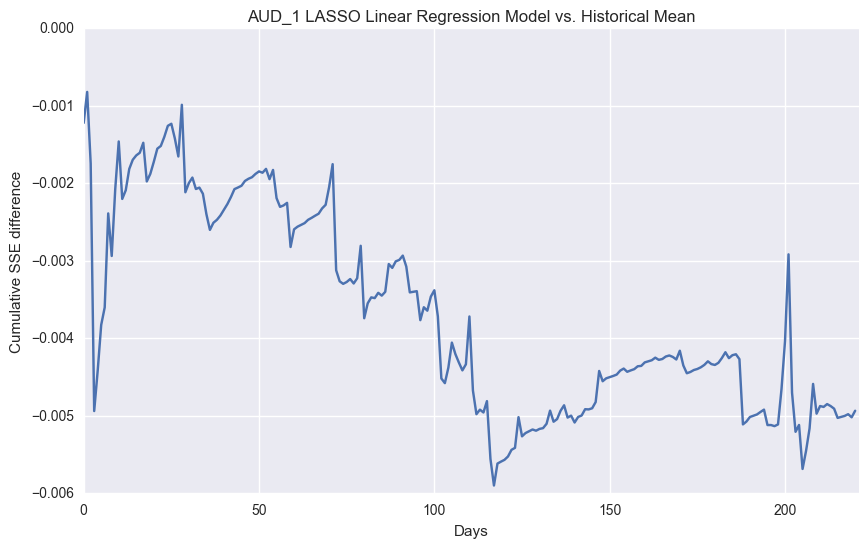

In [14]:
# CSSE 
lasso_RMSE_list = []
lasso_HM_SE_list = np.asarray(lasso_HM_SE_list).cumsum()
lasso_Model_SE_list = np.asarray(lasso_Model_SE_list).cumsum()

for i in range(0,len(HM_SE_list)):
    lasso_HM_SE_list[i] = lasso_HM_SE_list[i] / (i+1)
    lasso_Model_SE_list[i] = lasso_Model_SE_list[i] / (i+1)
    lasso_RMSE = np.sqrt(lasso_HM_SE_list[i]) - np.sqrt(lasso_Model_SE_list[i])
    lasso_RMSE_list.append(lasso_RMSE)

plt.figure(figsize=(10,6))
plt.plot(np.asarray(lasso_RMSE_list))
days = length - WindowSize
plt.xlim([0,days])
plt.xlabel('Days')
plt.ylabel('Cumulative SSE difference')
plt.title(Currency + ' LASSO Linear Regression Model vs. Historical Mean')

## Elastic Net 

In [15]:
EN_Model_SE_list = []
EN_HM_SE_list = []
from sklearn.linear_model import ElasticNetCV
EN = ElasticNetCV(cv = 10, max_iter=1000, normalize = True)

Lbound = 0
Ubound = WindowSize
Tbound = WindowSize

for i in range(WindowSize, length):
    EN_X_train = data.iloc[Lbound:Ubound, :]
    EN_Y_train = level_target.iloc[Lbound:Ubound]
    EN_X_test = data.iloc[Tbound-1, :]
    EN_Y_test = level_target.iloc[Tbound]
    
    # Linear Regression
    EN.fit(EN_X_train,EN_Y_train)
    EN_predictions = EN.predict(EN_X_test)
    EN_Model_SE_list.append((EN_predictions[0] - EN_Y_test)**2)
    
    # Historical Mean
    EN_historical_mean = np.mean(Y_train)
    EN_HM_SE_list.append((EN_historical_mean - EN_Y_test)**2)
    
    Lbound = Lbound + 1
    Ubound = Ubound + 1
    Tbound = Tbound + 1  

/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/

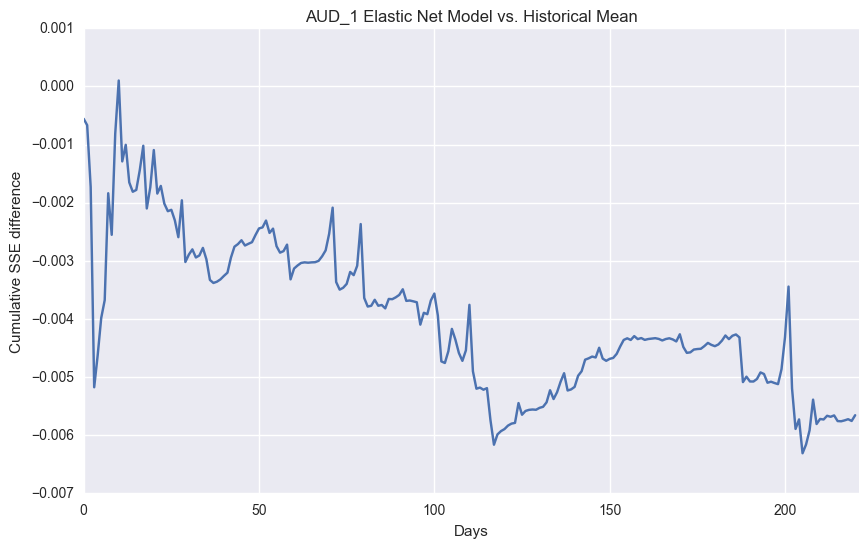

In [16]:
# CSSE 
EN_RMSE_list = []
EN_HM_SE_list = np.asarray(EN_HM_SE_list).cumsum()
EN_Model_SE_list = np.asarray(EN_Model_SE_list).cumsum()

for i in range(0,len(HM_SE_list)):
    EN_HM_SE_list[i] = EN_HM_SE_list[i] / (i+1)
    EN_Model_SE_list[i] = EN_Model_SE_list[i] / (i+1)
    EN_RMSE = np.sqrt(EN_HM_SE_list[i]) - np.sqrt(EN_Model_SE_list[i])
    EN_RMSE_list.append(EN_RMSE)

plt.figure(figsize=(10,6))
plt.plot(np.asarray(EN_RMSE_list))
days = length - WindowSize
plt.xlim([0,days])
plt.xlabel('Days')
plt.ylabel('Cumulative SSE difference')
plt.title(Currency + ' Elastic Net Model vs. Historical Mean')

## Random Forest Regressor

In [17]:
# Setting up data for RFR
# Running the cumulative SSE plot
RFR_Model_SE_list = []
RFR_HM_SE_list = []
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Lbound = 0
Ubound = WindowSize
Tbound = WindowSize

for i in range(WindowSize, length):
    RFR_X_train = data.iloc[Lbound:Ubound, :]
    RFR_Y_train = level_target.iloc[Lbound:Ubound]
    RFR_X_test = data.iloc[Tbound-1, :]
    RFR_Y_test = level_target.iloc[Tbound]
    
    # Random Forest Regressor
    rfr = RandomForestRegressor()
    est = [1,2,3,4,5,6,7,8,9,10]
    param_grid = dict(n_estimators = est)
    grid = GridSearchCV(rfr, param_grid, cv=10)
    grid.fit(RFR_X_train,RFR_Y_train)
    RFR_predictions = grid.predict(RFR_X_test)
    RFR_Model_SE_list.append((RFR_predictions[0] - RFR_Y_test)**2)
    
    # Historical Mean
    RFR_historical_mean = np.mean(RFR_Y_train)
    RFR_HM_SE_list.append((RFR_historical_mean - RFR_Y_test)**2)
    
    Lbound = Lbound + 1
    Ubound = Ubound + 1
    Tbound = Tbound + 1

/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

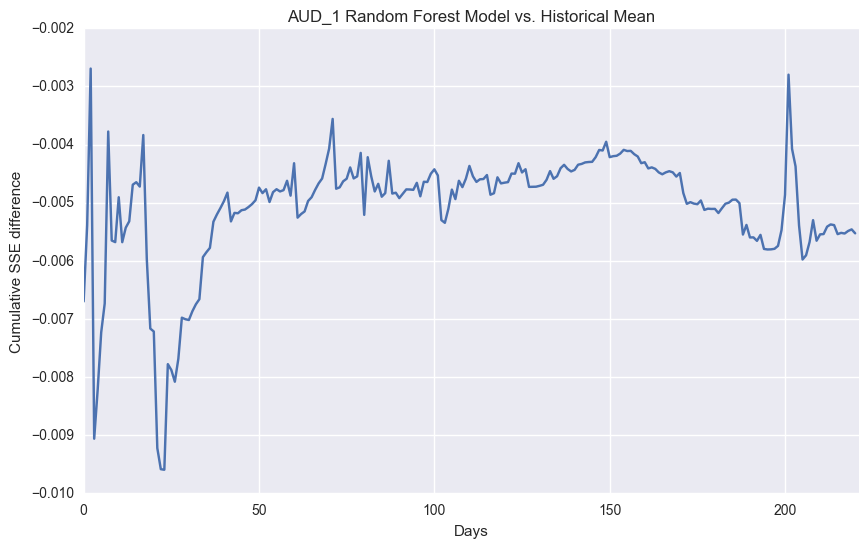

In [18]:
# CSSE 
RFR_RMSE_list = []
RFR_HM_SE_list = np.asarray(RFR_HM_SE_list).cumsum()
RFR_Model_SE_list = np.asarray(RFR_Model_SE_list).cumsum()

for i in range(0,len(RFR_HM_SE_list)):
    RFR_HM_SE_list[i] = RFR_HM_SE_list[i] / (i+1)
    RFR_Model_SE_list[i] = RFR_Model_SE_list[i] / (i+1)
    RFR_RMSE = np.sqrt(RFR_HM_SE_list[i]) - np.sqrt(RFR_Model_SE_list[i])
    RFR_RMSE_list.append(RFR_RMSE)

plt.figure(figsize=(10,6))
plt.plot(np.asarray(RFR_RMSE_list))
days = length - WindowSize
plt.xlim([0,days])
plt.xlabel('Days')
plt.ylabel('Cumulative SSE difference')
plt.title(Currency + ' Random Forest Model vs. Historical Mean')

## Binary Model

In [19]:
# Input Initialisation
logistic_Predictions = []
dtree_Predictions = []
rfc_Predictions = []

Lbound = 0
Ubound = WindowSize
Tbound = WindowSize

for i in range(WindowSize, length):
    binary_X_train = data.iloc[Lbound:Ubound, :]
    binary_Y_train = binary_target.iloc[Lbound:Ubound]
    binary_X_test = data.iloc[Tbound-1, :]
    binary_Y_test = binary_target.iloc[Tbound]

    #Logistic Regression
    from sklearn.linear_model import LogisticRegression
    logmodel = LogisticRegression()
    logmodel.fit(binary_X_train,binary_Y_train)
    logmodel_Predictions = logmodel.predict(binary_X_test)
    logistic_Predictions.append(logmodel_Predictions[0])
    
    #Decision Tree 
    from sklearn.tree import DecisionTreeClassifier
    dtree = DecisionTreeClassifier()
    dtree.fit(binary_X_train,binary_Y_train)
    dtreemodel_Predictions = dtree.predict(binary_X_test)
    dtree_Predictions.append(dtreemodel_Predictions[0])
    
    #Random Forest
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=30)
    rfc.fit(binary_X_train,binary_Y_train)
    rfcmodel_predictions = rfc.predict(binary_X_test)
    rfc_Predictions.append(rfcmodel_predictions[0])
    
    Lbound = Lbound + 1
    Ubound = Ubound + 1
    Tbound = Tbound + 1

/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/karimkharchafi/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

In [20]:
# Simple MA Trading Strategy
MA1 = movingAverage(data_file['FX Spot'],n1)
MA2 = movingAverage(data_file['FX Spot'],n2)
signals = crossOvers(MA1,MA2)

# Finding Initial Strategy
start = 0
while signals[start][0] < WindowSize:
    start = start + 1

period = (signals[start][0] - WindowSize) + 1


SMA_Predictions = []
for i in range(1,period):
    SMA_Predictions.append(signals[start][1])

for n in range(start+1,len(signals)):
    period = signals[n][0] - signals[n-1][0]
    if signals[n-1][1] == 1:
        SMA_Predictions.append(0)
    else:
        SMA_Predictions.append(1)
    for i in range(2,period+1):
        if signals[n][1] == 1:
            SMA_Predictions.append(0)
        else:
            SMA_Predictions.append(1)
    
    if n == (len(signals)-1):
        period = length - signals[n][0]
        for i in range(1,period+1):
            if signals[n][1] == 1:
                SMA_Predictions.append(1)
            else:
                SMA_Predictions.append(0)

In [21]:
# Momentum Based Predictions 
RW_Predictions = binary_target[WindowSize-1:length-1]

In [22]:
# Compare Accuracy of Binary model vs Simpla MA                
from sklearn import metrics                
print("The predictibility of the SMA strategy is equal to:", metrics.accuracy_score(binary_target[WindowSize:length],SMA_Predictions))
print('')
print("The predictibility of the logistic model is equal to: \n", metrics.accuracy_score(binary_target[WindowSize:length],logistic_Predictions))
print('')
print("The predictibility of the decision tree is equal to: \n", metrics.accuracy_score(binary_target[WindowSize:length], dtree_Predictions))
print('')
print("The predictibility of the random forest is equal to: \n", metrics.accuracy_score(binary_target[WindowSize:length], rfc_Predictions))
print('')  
print("The predictibility of the random walk is equal to: \n", metrics.accuracy_score(binary_target[WindowSize:length], RW_Predictions))
print('') 

The predictibility of the SMA strategy is equal to: 0.597285067873

The predictibility of the logistic model is equal to: 
 0.552036199095

The predictibility of the decision tree is equal to: 
 0.556561085973

The predictibility of the random forest is equal to: 
 0.556561085973

The predictibility of the random walk is equal to: 
 0.556561085973



In [23]:
# Build Buy/Hold vs SMA Trading Strategy        
startingMoney = 1000
values = MAvsBaH(n1,n2,startingMoney)

Buy and hold: 1099.87046632
Crossover MA: 1585.12212482


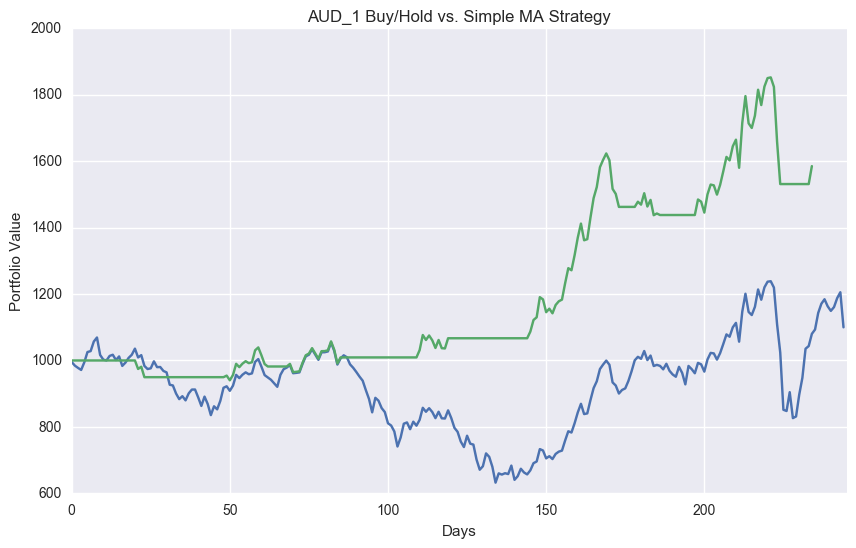

In [24]:
# Plotting
plt.figure(figsize=(10,6))
plt.plot(values[0])
plt.plot(values[1])
plt.xlim([0,length])
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.title(Currency + ' Buy/Hold vs. Simple MA Strategy')

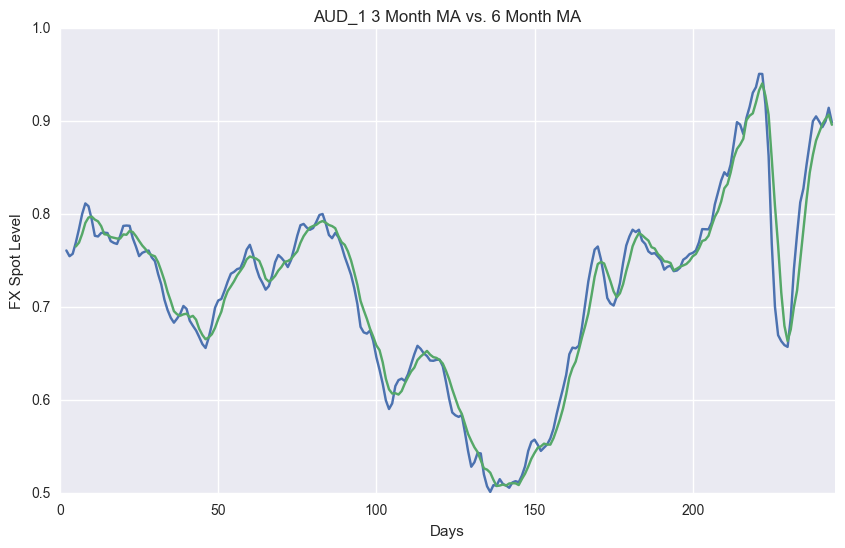

In [25]:
plt.figure(figsize=(10,6))
plt.plot(movingAverage(data_file['FX Spot'],3))
plt.plot(movingAverage(data_file['FX Spot'],6))
plt.xlim([0,length])
plt.xlabel('Days')
plt.ylabel('FX Spot Level')
plt.title(Currency + ' 3 Month MA vs. 6 Month MA')

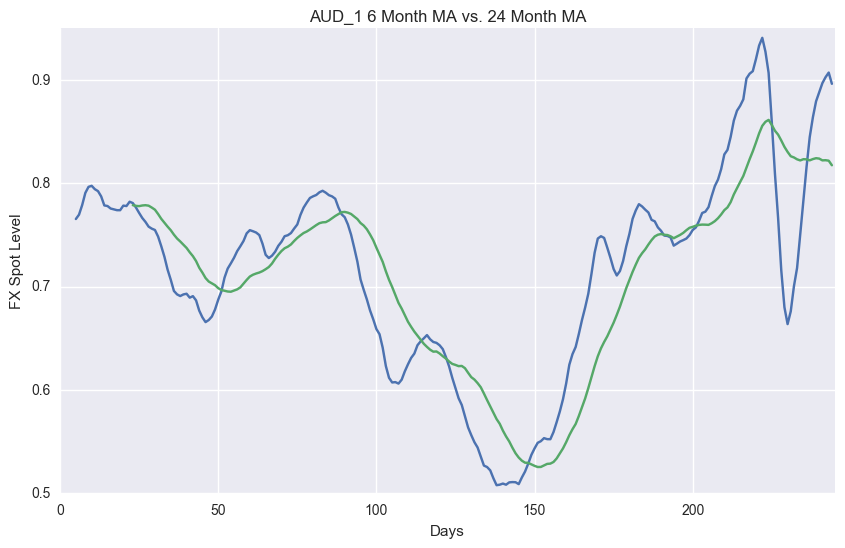

In [26]:
plt.figure(figsize=(10,6))
plt.plot(movingAverage(data_file['FX Spot'],6))
plt.plot(movingAverage(data_file['FX Spot'],24))
plt.xlim([0,length])
plt.xlabel('Days')
plt.ylabel('FX Spot Level')
plt.title(Currency + ' 6 Month MA vs. 24 Month MA')